#### This file imports, processess and models a predictive Toronto Bus Delay Classifier

### Library Imports

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import datetime as dt
from time import strftime
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
import pickle
import matplotlib, matplotlib_inline


### Dataset Import, Cleaning and Merging

In [3]:
# importing datasets. Using last 3 years data for relevancy and data inconsistency with earlier datasets
delay_22 = pd.read_excel("ttc-bus-delay-data-2022.xlsx", header=0)
delay_21 = pd.read_excel("ttc-bus-delay-data-2021.xlsx", sheet_name=None, header=0)
# delay_20 = pd.read_excel("ttc-bus-delay-data-2020.xlsx", sheet_name=None, header=0 )


In [4]:
# dropping erroneous columns
delay_21['Dec 21'].drop(columns='Unnamed: 10', inplace=True)

In [5]:
# setting all columns names to be the same
columnNames = delay_22.columns.to_list()
for key in delay_21:
    delay_21[key].columns = columnNames
# for key in delay_20:
    # delay_20[key].columns = columnNames

In [6]:
# concatenating dictionary into single dataframes
delay_21 = pd.concat(delay_21, ignore_index=True)
# delay_20 = pd.concat(delay_20, ignore_index=True)
# merging into one dataset
master_df = pd.concat([delay_21, delay_22], ignore_index=True)

In [7]:
# dropping rows with NA's and duplicates
master_df.dropna(inplace=True)
master_df.drop_duplicates(keep="last", inplace=True)

### Feature Engineering

In [8]:
# transforming the date field into month and day
master_df['Date - Month'] = master_df['Date'].dt.month
master_df['Date - Day Number'] = master_df['Date'].dt.day
# Something wrong with the format of time feature - could fix if had more time
master_df.drop(columns=['Date', 'Time'], axis=1, inplace=True)
# master_df['Date - Year'] = master_df['Date'].dt.year
# dropped vehicles since very sparse feature
master_df.drop(columns=["Vehicle"], inplace=True, axis=1)

In [9]:
# Transforming target variable into categorical variable
# 0 = 0-5 mins, 1 = 6-10 minutes, 2 = 10-20 minutes, 3 = 21-40 minutes, 4 = 40+ minutes
# chose these classes after checking spread of data
master_df['Delay (mins)'] = master_df['Min Delay'].apply(lambda x: 0 if (x <=5) else 1 if (6 < x <= 10) else 2 if (10 < x <= 20) else 3 if (21 < x <= 40) else 4)
master_df.drop(columns=['Min Delay'], inplace=True)

### Preprocessing Data for Modelling

In [11]:
CATEGORICAL_VARIABLES = ['Route', 'Day', 'Location', 'Incident', 'Direction', 'Date - Month', 'Date - Day Number']
# one hot encoded categorical variables
processed_df = pd.get_dummies(master_df[CATEGORICAL_VARIABLES])
# added other features to processed_df
processed_df['Gap (Mins)'] = master_df['Gap (Mins)']
processed_df['Delay (Mins)'] = master_df['Delay (mins)']

### Model Training

In [12]:
# separating test set completely
train_set, test_set = train_test_split(processed_df, test_size=0.2)
# splitting train set into X and Y
X_train = train_set.drop(columns=['Delay (Mins)'])
y_train = train_set['Delay (Mins)']
# splitting test set into X and Y
X_test = test_set.drop(columns=['Delay (Mins)'])
y_test = test_set['Delay (Mins)']

In [ ]:
# normalizing 'Min Gap' feature for model separately in test and train set to prevent leak
scaler = MinMaxScaler()
X_train['Gap (Mins)'] = scaler.fit_transform(X_train['Min Gap'].values.reshape(-1,1))
X_test['Gap (Mins)'] = scaler.transform(X_test['Min Gap'].values.reshape(-1,1))
X_train.drop(columns=['Min Gap'], inplace=True, axis=1)
X_test.drop(columns=['Min Gap'], inplace=True, axis=1)

In [13]:
# cross-validation for parameter-tuning.
# DID NOT USE because of limits on computational capacity
'''
cv_scores_mean = []
for depth in range(15,30):
    clf = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
    cv_scores_mean.append(cv_scores.mean())
'''

"\ncv_scores_mean = []\nfor depth in range(15,30):\n    clf = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)\n    cv_scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')\n    cv_scores_mean.append(cv_scores.mean())\n"

In [14]:
# training and fitting model. n_estimators = 30 because of computational limits
clf = RandomForestClassifier(n_estimators = 30, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
# saving model to pickle file
pickle.dump(clf, open("model.pkl", "wb"))

### Model Evaluation

In [15]:
# checking overfitting of model
y_train_pred = clf.predict_proba(X_train)
y_train_hat = clf.predict(X_train)
roc_auc_score(y_train, y_train_pred, multi_class='ovo')
# model overfit - would have adjusted depth through cross-validation 


0.9999964788986274

In [16]:
# testing model on untouched data
y_hat = clf.predict(X_test)
Y_prob = clf.predict(X_test)

In [17]:
# Evaluating metrics like accuracy, precision, recall and f1-score for all classes
print(classification_report(y_test, y_hat, labels = [0,1,2,3,4], target_names=['0-5 mins', '6-10 minutes', '10-20 minutes', '21-40 minutes', '40+ minutes']))

               precision    recall  f1-score   support

     0-5 mins       0.86      0.79      0.82      1123
 6-10 minutes       0.91      0.96      0.94      4542
10-20 minutes       0.91      0.95      0.93      4719
21-40 minutes       0.88      0.84      0.86      1890
  40+ minutes       0.81      0.59      0.68      1056

     accuracy                           0.90     13330
    macro avg       0.87      0.83      0.85     13330
 weighted avg       0.89      0.90      0.89     13330



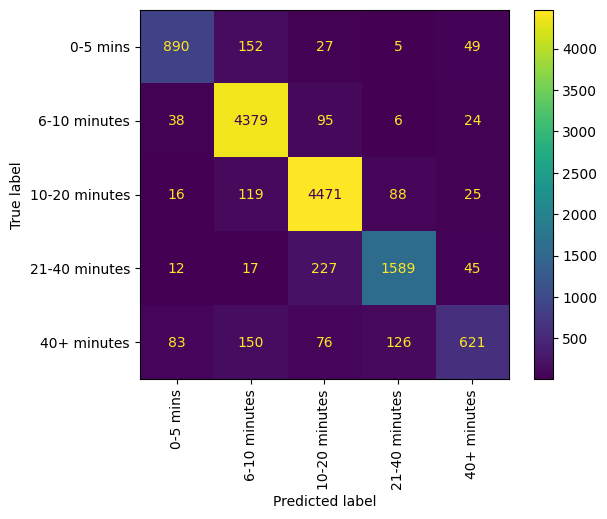

In [19]:
# plotting a confusion matrix
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, labels=[0,1,2,3,4], display_labels=['0-5 mins', '6-10 minutes', '10-20 minutes', '21-40 minutes', '40+ minutes'], xticks_rotation='vertical')

### Next Steps

1) Use all the data available ranging from 2014-2022
2) Cross-validate model to have better hyperparameters.
3) Plot feature importances to get rid of non-influential features for faster prediction in real-time